In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

/tmp/ipykernel_38/2734497031.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-05 18:32:07.937397: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonoteb

In [2]:
ds, ds_info = tfds.load('cats_vs_dogs', shuffle_files=True, as_supervised=True, with_info=True)

2024-02-05 18:32:17.240194: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:986] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 18:32:17.448145: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:986] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 18:32:17.448214: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:986] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 18:32:17.453150: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:986] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 18:32:17.453213: I external/local_xla/xla/stream_executor

2024-02-05 18:32:20.712084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


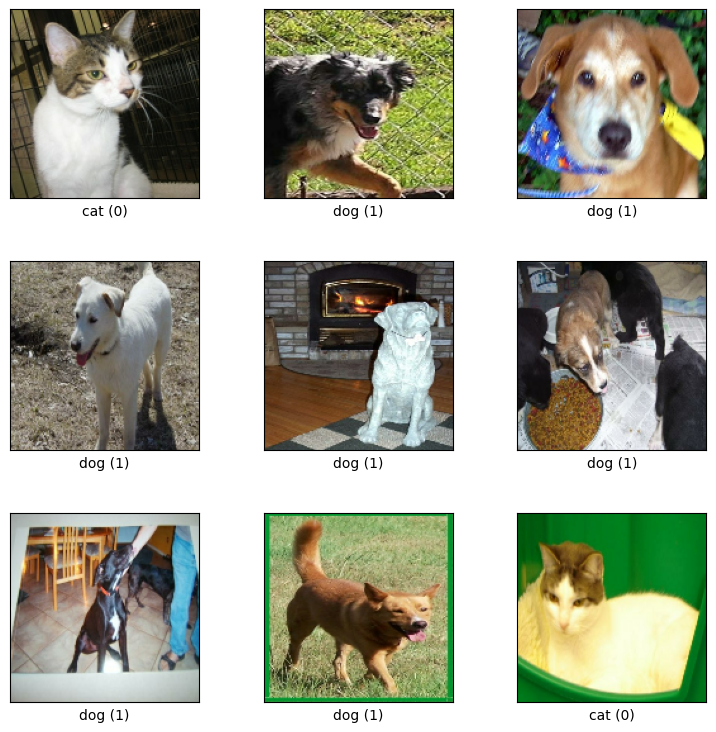

In [3]:
train_size = ds_info.splits['train'].num_examples

# Define split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate sizes as integers
train_size_int = int(train_size * train_ratio)
val_size_int = int(train_size * val_ratio)
test_size_int = int(train_size * test_ratio)

# Sequentially split into train, validation, and test sets
train_ds = ds['train'].take(train_size_int)  # 80% for training
val_ds = ds['train'].skip(train_size_int).take(val_size_int)  # 10% for validation
test_ds = ds['train'].skip(train_size_int + val_size_int)  # 10% for testing

# Function to resize and normalize images
def preprocess_image(image, label):
    image = tf.image.resize(image, (150, 150))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

# Apply preprocessing to the datasets
train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)

fig = tfds.show_examples(train_ds, ds_info)
# Create batches for training and validation
batch_size = 20
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)



In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=100,  # 2000 images = batch_size * steps
    epochs=1, 
    validation_data=val_ds,
    validation_steps=50,  # 1000 images = batch_size * steps
    verbose=2)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()